<a href="https://colab.research.google.com/github/subhayuroy/KickStarter/blob/master/KickStarter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using Feature Engineering to work with data from KickStarter projects. The first few rows of the data looks like this:

In [ ]:
import pandas as pd

ks = pd.read_csv('ks-projects-201801.csv', parse_dates=['deadline', 'launched'])
ks.head(6)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,successful,224,US,52375.0,52375.0,50000.00


The *state* column shows the outcome of the project

In [ ]:
print("Unique values in `state` column: ", list(ks.state.unique()))

Unique values in `state` column:  ['failed', 'canceled', 'successful', 'live', 'undefined', 'suspended']


**Prepare the target column**

In [ ]:
#Drop live projects
ks = ks.query('state != "live"')

# Add outcome column, "successful" == 1, others are 0
ks = ks.assign(outcome=(ks['state'] == 'successful').astype(int))

**Convert timestamps**

In [ ]:
ks = ks.assign(hour=ks.launched.dt.hour,
               day=ks.launched.dt.day,
               month=ks.launched.dt.month,
               year=ks.launched.dt.year)

**Prep categorical values**

In [ ]:
from sklearn.preprocessing import LabelEncoder

cat_features = ['category', 'currency', 'country']
encoder = LabelEncoder()

#Apply the LabelEncoder to each column
encoded = ks[cat_features].apply(encoder.fit_transform)

Collecting all of these features in a new dataframe that can be used to train a model.

In [ ]:
# Since ks and encoded have the same index and can easily be joined
data = ks[['goal', 'hour', 'day', 'month', 'year', 'outcome']].join(encoded)

data.head()

,goal,hour,day,month,year,outcome,category,currency,country
0,1000.0,12,11,8,2015,0,108,5,9
1,30000.0,4,2,9,2017,0,93,13,22
2,45000.0,0,12,1,2013,0,93,13,22
3,5000.0,3,17,3,2012,0,90,13,22
4,19500.0,8,4,7,2015,0,55,13,22


**Create training, validation, and test splits**

In [ ]:
valid_fraction = 0.1
valid_size = int(len(data) * valid_fraction)
# valid size == test size, last two sections of the data

train = data[:-2 * valid_size]
valid = data[-2 * valid_size:-valid_size]
test = data[-valid_size:]

**Train a model**

Using a LightGBM model. This is a tree-based model that typically provides the best performance, even compared to XGBoost. It's also relatively fast to train.

In [ ]:
import lightgbm as lgb

feature_cols = train.columns.drop('outcome')

dtrain = lgb.Dataset(train[feature_cols], label=train['outcome'])
dvalid = lgb.Dataset(valid[feature_cols], label=valid['outcome'])

param = {'num_leaves': 64, 'objective': 'binary'}
param['metric'] = 'auc'
num_round = 1000
bst = lgb.train(param, dtrain, num_round, valid_sets=[dvalid], early_stopping_rounds=10, verbose_eval=False)

**Make predictions & evaluate the model**

In [ ]:
from sklearn import metrics
ypred = bst.predict(test[feature_cols])
score = metrics.roc_auc_score(test['outcome'], ypred)

print(f"Test AUC score: {score}")

Test AUC score: 0.747615303004287


#Categorical Encoding

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

ks = pd.read_csv('ks-projects-201801.csv', parse_dates=['deadline', 'launched'])

# Drop live projects
ks = ks.query('state != "live"')

# Add outcome column, "successful" == 1, others are 0
ks = ks.assign(outcome=(ks['state'] == 'successful').astype(int))

# Timestamp features
ks = ks.assign(hour=ks.launched.dt.hour,
               day=ks.launched.dt.day,
               month=ks.launched.dt.month,
               year=ks.launched.dt.year)

# Label encoding
cat_features = ['category', 'currency', 'country']
encoder = LabelEncoder()
encoded = ks[cat_features].apply(encoder.fit_transform)

data_cols = ['goal', 'hour', 'day', 'month', 'year', 'outcome']
data = ks[data_cols].join(encoded)

# Defining  functions that will help us test our encodings
import lightgbm as lgb
from sklearn import metrics

def get_data_splits(dataframe, valid_fraction=0.1):
    valid_fraction = 0.1
    valid_size = int(len(dataframe) * valid_fraction)

    train = dataframe[:-valid_size * 2]
    # valid size == test size, last two sections of the data
    valid = dataframe[-valid_size * 2:-valid_size]
    test = dataframe[-valid_size:]
    
    return train, valid, test

def train_model(train, valid):
    feature_cols = train.columns.drop('outcome')

    dtrain = lgb.Dataset(train[feature_cols], label=train['outcome'])
    dvalid = lgb.Dataset(valid[feature_cols], label=valid['outcome'])

    param = {'num_leaves': 64, 'objective': 'binary', 
             'metric': 'auc', 'seed': 7}
    bst = lgb.train(param, dtrain, num_boost_round=1000, valid_sets=[dvalid], 
                    early_stopping_rounds=10, verbose_eval=False)

    valid_pred = bst.predict(valid[feature_cols])
    valid_score = metrics.roc_auc_score(valid['outcome'], valid_pred)
    print(f"Validation AUC score: {valid_score:.4f}")

In [ ]:
# Train a model (on the baseline data)
train, valid, test = get_data_splits(data)
train_model(train, valid)

Validation AUC score: 0.7467


**Count Encoding**

Count encoding replaces each categorical value with the number of times it appears in the dataset.

In [ ]:
!pip install category_encoders

     |████████████████████████████████| 81kB 2.2MB/s 


In [ ]:
import category_encoders as ce
cat_features = ['category', 'currency', 'country']

# Create the encoder
count_enc = ce.CountEncoder()

# Transform the features, rename the columns with the _count suffix, and join to dataframe
count_encoded = count_enc.fit_transform(ks[cat_features])
data = data.join(count_encoded.add_suffix("_count"))

# Train a model 
train, valid, test = get_data_splits(data)
train_model(train, valid)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Validation AUC score: 0.7486


Adding the count encoding features increase the validation score from 0.7467 to 0.7486, only a slight improvement.

**Target Encoding**

Target encoding replaces a categorical value with the average value of the target for that value of the feature.

In [ ]:
# Create the encoder
target_enc = ce.TargetEncoder(cols=cat_features)
target_enc.fit(train[cat_features], train['outcome'])

# Transform the features, rename the columns with _target suffix, and join to dataframe
train_TE = train.join(target_enc.transform(train[cat_features]).add_suffix('_target'))
valid_TE = valid.join(target_enc.transform(valid[cat_features]).add_suffix('_target'))

# Train a model
train_model(train_TE, valid_TE)

Validation AUC score: 0.7491


The validation score is higher again, from 0.7467 to 0.7491.

**CatBoost Encoding**

Finally, we'll look at CatBoost encoding. This is similar to target encoding in that it's based on the target probablity for a given value. However with CatBoost, for each row, the target probability is calculated only from the rows before it.

In [ ]:
# Create the encoder
target_enc = ce.CatBoostEncoder(cols=cat_features)
target_enc.fit(train[cat_features], train['outcome'])

# Transform the features, rename columns with _cb suffix, and join to dataframe
train_CBE = train.join(target_enc.transform(train[cat_features]).add_suffix('_cb'))
valid_CBE = valid.join(target_enc.transform(valid[cat_features]).add_suffix('_cb'))

# Train a model
train_model(train_CBE, valid_CBE)

Validation AUC score: 0.7492


This does slightly better than target encoding.

#Feature Generation

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.preprocessing import LabelEncoder

ks = pd.read_csv('ks-projects-201801.csv', parse_dates=['deadline', 'launched'])

# Drop live projects
ks = ks.query('state != "live"')

# Add outcome column, "successful" == 1, others are 0
ks = ks.assign(outcome=(ks['state'] == 'successful').astype(int))

# Timestamp features
ks = ks.assign(hour=ks.launched.dt.hour,
               day=ks.launched.dt.day,
               month=ks.launched.dt.month,
               year=ks.launched.dt.year)

# Label encoding
cat_features = ['category', 'currency', 'country']
encoder = LabelEncoder()
encoded = ks[cat_features].apply(encoder.fit_transform)

data_cols = ['goal', 'hour', 'day', 'month', 'year', 'outcome']
baseline_data = ks[data_cols].join(encoded)

**Interactions**

One of the easiest ways to create new features is by combining categorical variables. 

In [2]:
interactions = ks['category'] + "_" + ks['country']
print(interactions.head(5))

0            Poetry_GB
1    Narrative Film_US
2    Narrative Film_US
3             Music_US
4      Film & Video_US
dtype: object


In [3]:
label_enc = LabelEncoder()
data_interaction = baseline_data.assign(category_country=label_enc.fit_transform(interactions))
data_interaction.head()

,goal,hour,day,month,year,outcome,category,currency,country,category_country
0,1000.0,12,11,8,2015,0,108,5,9,1900
1,30000.0,4,2,9,2017,0,93,13,22,1630
2,45000.0,0,12,1,2013,0,93,13,22,1630
3,5000.0,3,17,3,2012,0,90,13,22,1595
4,19500.0,8,4,7,2015,0,55,13,22,979


**Number of projects in the last week**

Next, we'll count the number of projects launched in the preceeding week for each record. 

In [4]:
# First, creating a Series with a timestamp index
launched = pd.Series(ks.index, index=ks.launched, name="count_7_days").sort_index()
launched.head(20)

launched
1970-01-01 01:00:00     94579
1970-01-01 01:00:00    319002
1970-01-01 01:00:00    247913
1970-01-01 01:00:00     48147
1970-01-01 01:00:00     75397
1970-01-01 01:00:00      2842
1970-01-01 01:00:00    273779
2009-04-21 21:02:48    169268
2009-04-23 00:07:53    322000
2009-04-24 21:52:03    138572
2009-04-25 17:36:21    325391
2009-04-27 14:10:39    122662
2009-04-28 13:55:41    213711
2009-04-29 02:04:21    345606
2009-04-29 02:58:50    235255
2009-04-29 04:37:37     98954
2009-04-29 05:26:32    342226
2009-04-29 06:43:44    275091
2009-04-29 13:52:03    284115
2009-04-29 22:08:13     32898
Name: count_7_days, dtype: int64

launched
1970-01-01 01:00:00     0.0
1970-01-01 01:00:00     1.0
1970-01-01 01:00:00     2.0
1970-01-01 01:00:00     3.0
1970-01-01 01:00:00     4.0
1970-01-01 01:00:00     5.0
1970-01-01 01:00:00     6.0
2009-04-21 21:02:48     0.0
2009-04-23 00:07:53     1.0
2009-04-24 21:52:03     2.0
2009-04-25 17:36:21     3.0
2009-04-27 14:10:39     4.0
2009-04-28 13:55:41     5.0
2009-04-29 02:04:21     5.0
2009-04-29 02:58:50     6.0
2009-04-29 04:37:37     7.0
2009-04-29 05:26:32     8.0
2009-04-29 06:43:44     9.0
2009-04-29 13:52:03    10.0
2009-04-29 22:08:13    11.0
Name: count_7_days, dtype: float64


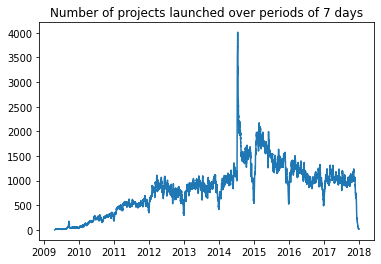

In [5]:
count_7_days = launched.rolling('7d').count() - 1
print(count_7_days.head(20))

# Ignore records with broken launch dates
plt.plot(count_7_days[7:]);
plt.title("Number of projects launched over periods of 7 days");

In [6]:
count_7_days.index = launched.values
count_7_days = count_7_days.reindex(ks.index)

In [7]:
count_7_days.head(10)

0    1409.0
1     957.0
2     739.0
3     907.0
4    1429.0
5    1284.0
6    1119.0
7    1391.0
8    1043.0
9    3199.0
Name: count_7_days, dtype: float64

In [8]:
baseline_data.join(count_7_days).head(10)

,goal,hour,day,month,year,outcome,category,currency,country,count_7_days
0,1000.0,12,11,8,2015,0,108,5,9,1409.0
1,30000.0,4,2,9,2017,0,93,13,22,957.0
2,45000.0,0,12,1,2013,0,93,13,22,739.0
3,5000.0,3,17,3,2012,0,90,13,22,907.0
4,19500.0,8,4,7,2015,0,55,13,22,1429.0
5,50000.0,13,26,2,2016,1,123,13,22,1284.0
6,1000.0,18,1,12,2014,1,58,13,22,1119.0
7,25000.0,20,1,2,2016,0,41,13,22,1391.0
8,125000.0,18,24,4,2014,0,113,13,22,1043.0
9,65000.0,21,11,7,2014,0,39,13,22,3199.0


**Time since the last project in the same category**

In [9]:
def time_since_last_project(series):
    # Return the time in hours
    return series.diff().dt.total_seconds() / 3600.

df = ks[['category', 'launched']].sort_values('launched')
timedeltas = df.groupby('category').transform(time_since_last_project)
timedeltas.head(20)

,launched
94579,NaN
319002,NaN
247913,NaN
48147,NaN
75397,NaN
2842,0.000000
273779,NaN
169268,NaN
322000,NaN
138572,NaN


In [10]:
# Final time since last project
timedeltas = timedeltas.fillna(timedeltas.median()).reindex(baseline_data.index)
timedeltas.head(20)

,launched
0,18.606111
1,5.592778
2,1.313611
3,0.635000
4,16.661389
5,2.629722
6,0.367500
7,12.286111
8,14.243611
9,0.174722


**Transforming numerical features**

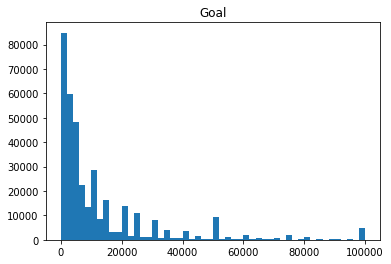

In [11]:
plt.hist(ks.goal, range=(0, 100000), bins=50);
plt.title('Goal');

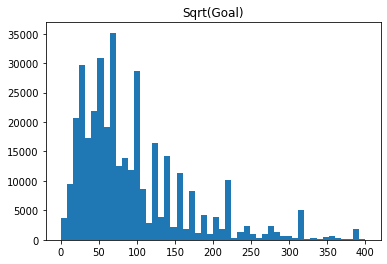

In [12]:
plt.hist(np.sqrt(ks.goal), range=(0, 400), bins=50);
plt.title('Sqrt(Goal)');

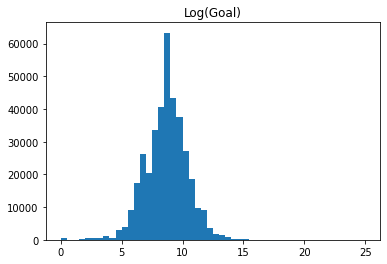

In [13]:
plt.hist(np.log(ks.goal), range=(0, 25), bins=50);
plt.title('Log(Goal)');

The log transformation won't help our model since tree-based models are scale invariant. However, this should help if we had a linear model or neural network.

Other transformations include squares and other powers, exponentials, etc. These might help the model discriminate, like the kernel trick for SVMs. Again, it takes a bit of experimentation to see what works. One method is to create a bunch of new features and later choose the best ones with feature selection algorithms.